Initialize

In [1]:
print('Begin Importing (0/4)')
from All_Materials import *
print('Imported All Materials (1/4)')
import All_Charged_Materials
print('Imported Charged Materials (2/4)')
import ZachsMaterials
print('Imported Zachs Materials (3/4)')
import ZungersMaterials
print('Imported Zungers Materials (4/4)')
import matplotlib
import scipy
%matplotlib inline
mat_dict.update(ZachsMaterials.mat_dict)
mat_dict.update(ZungersMaterials.mat_dict)
ts_dict.update(ZachsMaterials.ts_dict)
ts_dict.update(ZungersMaterials.ts_dict)
print('Updated Dicts')
comps = False
if comps:
    figure_folder = 'D:\\My Stuff\\Dropbox\\Research\\compfigures'
else:
    figure_folder = 'D:\\My Stuff\\Dropbox\\Research\\Papers\\Figures'
    
def savefig(fname, pyplot=plt):
    os.makedirs(figure_folder, exist_ok=True)
    pyplot.savefig(os.path.join(figure_folder, '{}.png'.format(fname)), dpi=300, bbox_inches='tight')
    pyplot.show()
print('Loaded')



Begin Importing (0/4)
Imported All Materials (1/4)
Imported Charged Materials (2/4)
Imported Zachs Materials (3/4)
Imported Zungers Materials (4/4)
Updated Dicts
Loaded


In [2]:
print(ts_dict['bacoo3']['lb'][1]['energy'])
print(max(max(ts_dict['bacoo3']['ub'][1][0]['energies']), 
          max(ts_dict['bacoo3']['ub'][1][1]['energies'])))

-473.10230264
-472.97061171


Functions

In [3]:
def get_unit_criteria(run, material):
    if 'zunger' in run['base']['material']:
        unit_criteria = {
            'defect_type': {'$exists': False},
            'ts_type': {'$exists': False},
            'material': {'$all': ['zunger', material], '$in': ['spinel', 'perovskite'], '$nin': []},
            'labels' : {
                '$all' : ['unit_cell'],
                '$nin' : ['surface']}
        }
    elif 'from_zach' in run['base']['material']:
        unit_criteria = {
            'defect_type': {'$exists': False},
            'ts_type': {'$exists': False},
            'material': {'$all': ['from_zach', material], '$in': ['spinel', 'perovskite'], '$nin': []},
            'labels' : {
                '$all' : ['unit_cell'],
                '$nin' : ['surface']}
        }
    else:
        unit_criteria = {
            'defect_type': {'$exists': False},
            'ts_type': {'$exists': False},
            'material': {'$all': [material], '$in': ['spinel', 'perovskite'], '$nin': ['from_zach', 'zunger']},
            'labels' : {
                '$all' : ['unit_cell'],
                '$nin' : ['surface']}
        }
    return unit_criteria
print('done')

done


In [4]:
material = 'znmno3'
mat = mat_dict[material]
mat_unit_criteria = get_unit_criteria(mat, material)
i = 5
units = list(db.database.find(mat_unit_criteria).sort('energy'))
unit = units[0]
Poscar.from_dict(unit['poscar']).write_file('D:\\Users\\theme\\Documents\\scrap\\POSCAR')
get_file(fs, unit['vasprun'], new_file='D:\\Users\\theme\\Documents\\scrap\\vasprun.xml')

print(mat['base']['band_gap_base'])
print(mat['finals'][i]['diffusion_distance'])

0.0
2.533854527668464


Make CSV

In [5]:
csv_dict = Csv_dict()


neb = []
pc = []
label_list = []
for material in list(mat_dict.keys())[:]:
    # if material in done:
    if True:
        mat = mat_dict[material]
        mat_unit_criteria = get_unit_criteria(mat, material)
        units = list(db.database.find(mat_unit_criteria).sort('energy'))
        if not units:
            continue
        unit = units[0]

        # vasprun = get_vasprun(unit)
        thermo, lb_bars, ub_bars, delta = get_bars(mat, ts_dict[material])
        bars_list = [thermo, lb_bars, ub_bars]
        bulk = mat['base']
        start = mat['start']
        base = mat['base']
        finals = mat['finals']
        best_i = None
        best_avg = 9e9
        for i in range(len(ub_bars)):
            ub = ub_bars[i]
            lb = lb_bars[i]
            if ub:
                if lb:
                    avg = (ub + lb) /2
                    if avg < best_avg:
                        best_i = i
                        best_avg = avg
        if best_i == None:
            continue
            # print(lb_bars)
        # for i in range(1, len(mat['finals'])+1):
        for i in [best_i]:
            if thermo[i] and lb_bars[i] and ub_bars[i]:
                final = finals[i-1]
                lb = ts_dict[material]['lb'][i-1]
                ub = ts_dict[material]['ub'][i-1]

                ovac_e = start['energy'] - bulk['energy']
                ovac_final = start['energy'] - bulk['energy']
                lb_e = lb['energy'] - start['energy']
                ub_e = max(max([x['energies'] for x in ub])) - start['energy']
                csv_dict.add_material(mat_dict[material]['base'], mat_dict[material]['start'],
                                      mat_dict[material]['finals'][i - 1], ovac_e, ovac_final, ub_e, lb_e, i)

                for name, property in properties:
                    value = property.get(unit, base, start, finals[i-1])
                    if type(value) == dict:
                        for k in value:
                            csv_dict.add_property(unit, '{}_{}'.format(name,k), value[k], i)
                    else:
                        csv_dict.add_property(unit, name, value, i)

                for name, property in ts_properties:
                    value = property.get(unit, base, start, finals[i-1], lb, ub)
                    if type(value) == dict:
                        for k in value:
                            csv_dict.add_property(unit, '{}_{}'.format(name,k), value[k], i)
                    else:
                        csv_dict.add_ts_property(unit, name, value, i)
                csv_dict.add_ts_property(lb, 'neb', int('IMAGES' in lb['incar']), i)
                    
                if 'IMAGES' in ts_dict[material]['lb'][i-1]['incar']:
                    neb.append(ub_e-lb_e)
                else:
                    pc.append(ub_e-lb_e)
with open('D:\\My Stuff\\Dropbox\\Research\\Papers\\Figures\\materials.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    additional_properties = ['lb', 'ub', 'type', 'o_p_band_center', 'band_gap', 'volume_per_atom', 'formation_energy', 
                             'atomization_energy']
    writer.writerow(['material', 'ovac'] + additional_properties)
    for material in csv_dict.materials:
        for i in csv_dict.materials[material]:
            line = list([csv_dict.materials[material][i][prop] for prop in additional_properties])
            line = [material, str(min(csv_dict.materials[material][i]['ovac'],csv_dict.materials[material][i]['ovac_final']))] + line
            writer.writerow(line)
dft_error = 0.15
def print_info(property, x=[], ydelta=[], degree=1):
    if x == []:
        x=np.array(csv_dict.get_column(property))
    materials = np.array(csv_dict.get_column('material'))
    y=np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2
    w=np.array(abs(csv_dict.get_column('ub')-np.array(csv_dict.get_column('lb')))) + dft_error
    w=(1/w)**3
    x=x[np.where(y<cutoff)]
    w=w[np.where(y<cutoff)]
    materials=materials[np.where(y<cutoff)]
    y=y[np.where(y<cutoff)]
    
    # # is spinel
    # is_type = ['4' in x for x in materials]
    # x=x[np.where(is_type)]
    # w=w[np.where(is_type)]
    # y=y[np.where(is_type)]
    # # print(materials)
    # # print(is_type)
    # materials=materials[np.where(is_type)]
    
    if ydelta != []:
        y=y+ydelta
    fit = np.polyfit(x, y, degree, w=w)
    f = np.poly1d(fit)
    ybar = np.average(y,weights=w)
    ssreg = w*(f(x) - ybar)**2
    sstot = w*(y - ybar)**2
    print('{:31} : {:5.2f}'.format(property, sum(ssreg)/sum(sstot)))
    return([min(x), max(x)], [f(min(x)), f(max(x))])
print('done')

['alv2o4', 'spinel', 'zunger'] : formation_energy -2.9449998149999996
['perovskite', 'baceo3', 'from_zach'] : formation_energy -3.1756469724999987
['perovskite', 'bacoo3'] : formation_energy -1.833648486
['perovskite', 'bafeo3'] : formation_energy -2.0191163079999996
['perovskite', 'bahfo3', 'from_zach'] : formation_energy -3.3964883710000002
['perovskite', 'bamn3po3'] : formation_energy -2.2625683354022974
['perovskite', 'baseo3'] : formation_energy -1.9062227682187511
['perovskite', 'basno3', 'from_zach'] : formation_energy -2.1709670800000005
['perovskite', 'batao3'] : formation_energy -2.87691223
['perovskite', 'bazro3', 'from_zach'] : formation_energy -3.3456299560000007
['perovskite', 'bialo3'] : formation_energy -2.014946689
['perovskite', 'bicoo3'] : formation_energy -1.0739940940000003
['perovskite', 'biino3'] : formation_energy -1.375519950999999
['perovskite', 'bimno3'] : formation_energy -1.5489237753189642
['perovskite', 'bisbo3'] : formation_energy -1.1988576119999999
['p

Setup Regression


In [6]:
w=np.array(abs(csv_dict.get_column('ub')-np.array(csv_dict.get_column('lb'))))
msist05 = sum(1/(np.sqrt(w**2 +0.05**2)) / (1/0.05 * len(w)))
msist10 = sum(1/(np.sqrt(w**2 +0.1**2)) / (1/0.1 * len(w)))
msist15 = sum(1/np.sqrt((w**2+0.15**2)) / (1/0.15 * len(w)))
msist052 = sum(1/(w**2 +0.05**2 )/ (1/0.05**2 * len(w)))
msist102 = sum(1/(w**2 +0.1**2 )/ (1/0.1**2 * len(w)))
msist152 = sum(1/(w**2+0.15**2) / (1/0.15**2 * len(w)))
print('''
DFTerror=0.05 1st {}
DFTerror=0.10 1st {}
DFTerror=0.15 1st {}

DFTerror=0.05 2nd {}
DFTerror=0.10 2nd {}
DFTerror=0.15 2nd {}
'''.format(msist05, msist10, msist15, msist052, msist102, msist152))


DFTerror=0.05 1st 0.4863971671610008
DFTerror=0.10 1st 0.5791374622661035
DFTerror=0.15 1st 0.6417119825142885

DFTerror=0.05 2nd 0.39763069282799524
DFTerror=0.10 2nd 0.4737169753351759
DFTerror=0.15 2nd 0.5318886771192256



In [7]:
import scipy
cutoff = 10
print(csv_dict.get_header())
ovac=np.array(csv_dict.get_column('ovac'))
bg=np.array(csv_dict.get_column('band_gap'))
avg=np.array(csv_dict.get_column('bond_avg_length'))

label_list = np.array(csv_dict.get_column('material'))
i_list = np.array(csv_dict.get_column('i'))
y=np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2
ovac=ovac[np.where(y<cutoff)]
bg=bg[np.where(y<cutoff)]
avg=avg[np.where(y<cutoff)]
label_list = label_list[np.where(y<cutoff)]
i_list = i_list[np.where(y<cutoff)]
y=y[np.where(y<cutoff)]

master_linreg = scipy.stats.linregress(ovac, y)
print(master_linreg)
f = lambda x : master_linreg.intercept + master_linreg.slope*x
f_ovac = f(ovac)

bg_linreg = scipy.stats.linregress(bg, y)
print(bg_linreg)
bg_f = lambda x : bg_linreg.intercept + bg_linreg.slope*x
f_bg = bg_f(ovac)

master_linreg2 = scipy.stats.linregress(avg, y - f(ovac))
print(master_linreg)
f2 = lambda x : master_linreg2.intercept + master_linreg2.slope*x


min_cutoff = -100
fermi_shift_cutoff = 0.3
combinations = [
    (
        'metal',
        np.int64(np.array(csv_dict.get_column('band_gap')) < 0.01)
    ),
    (
        'relative_op' , 
        np.array(csv_dict.get_column('o_p_band_center')) - np.array(csv_dict.get_column('efermi'))
    ),
    (
        'relative_op_vac',
        np.array(csv_dict.get_column('o_p_band_center')) - np.array(csv_dict.get_column('efermi_vac'))
    ),
    (
        'fermi_shift',
        np.array(csv_dict.get_column('efermi_vac')) - np.array(csv_dict.get_column('efermi'))
    ),
    (
        'fermi_shift_binary',
        np.int64(np.array(csv_dict.get_column('efermi_vac')) - np.array(csv_dict.get_column('efermi')) > fermi_shift_cutoff)
    ),
    (
        'bg_left',
        np.array(csv_dict.get_column('band_gap')) - (np.array(csv_dict.get_column('efermi_vac')) - np.array(csv_dict.get_column('efermi')))
    ),
    (
        'ts_shift',
        np.array(csv_dict.get_column('ts_efermi')) - np.array(csv_dict.get_column('efermi_vac'))
    ),
    (
        'ts_shift_binary',
        np.int64(np.array(csv_dict.get_column('ts_efermi')) - np.array(csv_dict.get_column('efermi_vac')) > fermi_shift_cutoff)
    ),
    (
        'ts_total_shift',
        np.array(csv_dict.get_column('ts_efermi')) - np.array(csv_dict.get_column('efermi'))
    ),
]



['material', 'i', 'ovac', 'lb', 'ub', 'type', 'o_p_band_center', 'o_p_band_center_with_conduction', 'band_gap', 'band_gap_base', 'efermi', 'efermi_vac', 'volume_per_atom', 'bond_A_Bonds', 'bond_A_length', 'bond_B_Bonds', 'bond_B_length', 'bond_avg_length', 'bond_final_A_Bonds', 'bond_final_A_length', 'bond_final_B_Bonds', 'bond_final_B_length', 'bond_final_avg_length', 'crit_triangle', 'diffusion_distance', 'crit_triangle_adjusted', 'formation_energy', 'atomization_energy', 'pauling_diff', 'pauling_diff_start', 'pauling_diff_weighted', 'pauling_diff_start_weighted']
LinregressResult(slope=0.26497192701260347, intercept=-0.9126749390090214, rvalue=0.6176395027671263, pvalue=1.5979644957529327e-11, stderr=0.03461627860970114)
LinregressResult(slope=0.28499969109818, intercept=0.8216751973290463, rvalue=0.4732931821651218, pvalue=9.788625032174741e-07, stderr=0.054422864624709674)
LinregressResult(slope=0.26497192701260347, intercept=-0.9126749390090214, rvalue=0.6176395027671263, pvalue=

Linear Regression

In [8]:
for property in csv_dict.get_header()[2:3] + csv_dict.get_header()[6:]:
    print_info(property)
    # print(linreg)
    
for property, x in combinations:
    print_info(property, x)

print('\nAfter Ovac\n')
for property in csv_dict.get_header()[2:3] + csv_dict.get_header()[6:]:
    print_info(property, ydelta=-f_ovac)
    
for property, x in combinations:
    print_info(property, x=x, ydelta=-f_ovac)
    
y=np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2
y = y - f(ovac)
num = 25
over_mat = label_list[y.argsort()[:num][::1]]
over_i = i_list[y.argsort()[:num][::1]]
under_mat = label_list[y.argsort()[-num:][::1]]
under_i = i_list[y.argsort()[-num:][::1]]
print('Over Estimated')
print(over_mat)
print(over_i)
print('Under Estimated')
print(under_mat)
print(under_i)



# print(i_list)
# print(np.int64(x>0.1))
# print(np.average(y))
# print(max(y))
# print(min(y))
# print(y)

ovac                            :  0.43
o_p_band_center                 :  0.14
o_p_band_center_with_conduction :  0.04
band_gap                        :  0.30
band_gap_base                   :  0.14
efermi                          :  0.10
efermi_vac                      :  0.24
volume_per_atom                 :  0.25
bond_A_Bonds                    :  0.38
bond_A_length                   :  0.44
bond_B_Bonds                    :  0.35
bond_B_length                   :  0.06
bond_avg_length                 :  0.39
bond_final_A_Bonds              :  0.41
bond_final_A_length             :  0.45
bond_final_B_Bonds              :  0.41
bond_final_B_length             :  0.01
bond_final_avg_length           :  0.40
crit_triangle                   :  0.03
diffusion_distance              :  0.02
crit_triangle_adjusted          :  0.37
formation_energy                :  0.06
atomization_energy              :  0.08
pauling_diff                    :  0.17
pauling_diff_start              :  0.14


D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Quadratic Regression

In [9]:
for property in csv_dict.get_header()[2:3] + csv_dict.get_header()[6:]:
    print_info(property, degree=2)
    # print(linreg)
    
for property, x in combinations:
    print_info(property, x, degree=2)

print('\nAfter Ovac\n')
for property in csv_dict.get_header()[2:3] + csv_dict.get_header()[6:]:
    print_info(property, ydelta=-f_ovac, degree=2)
    
for property, x in combinations:
    print_info(property, x=x, ydelta=-f_ovac, degree=2)

ovac                            :  0.43
o_p_band_center                 :  0.14
o_p_band_center_with_conduction :  0.04
band_gap                        :  0.30
band_gap_base                   :  0.16
efermi                          :  0.11
efermi_vac                      :  0.24
volume_per_atom                 :  0.29
bond_A_Bonds                    :  0.50
bond_A_length                   :  0.50
bond_B_Bonds                    :  0.35
bond_B_length                   :  0.29
bond_avg_length                 :  0.53
bond_final_A_Bonds              :  0.50
bond_final_A_length             :  0.51
bond_final_B_Bonds              :  0.45
bond_final_B_length             :  0.38
bond_final_avg_length           :  0.54
crit_triangle                   :  0.06
diffusion_distance              :  0.05
crit_triangle_adjusted          :  0.39
formation_energy                :  0.09
atomization_energy              :  0.08
pauling_diff                    :  0.17
pauling_diff_start              :  0.14


D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:86: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:6: RankWarning: Polyfit may be poorly conditioned
  
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:106: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may

Oxygen Vacancy

ovac                            :  0.43

Pathway Count:  517
Calculated UB:  325
Material Count: 97


Spinel Count     : 22  
Perovskite Count : 75

0
0


D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


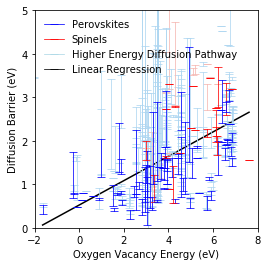

In [10]:
if comps:
    fig_all, ax_all = plt.subplots(figsize=(4, 4))
else:
    fig_all, ax_all = plt.subplots(figsize=(4, 4))


ax_all.plot([-1], [-1], color='blue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.plot([-1], [-1], color='red', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.plot([-1], [-1], color='lightblue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )

ax_all.plot([-1], [-1], color='black', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.legend(['Perovskites', 'Spinels', 'Higher Energy Diffusion Pathway', 'Linear Regression'], loc='upper left', 
              framealpha=1, frameon=False)
ax_all.set_ylabel('Diffusion Barrier (eV)')
ax_all.set_xlabel('Oxygen Vacancy Energy (eV)')

ax_all.set_ylim([0,5])
ax_all.set_xlim([-2, 8])

labels = []



material_count = 0
ub_count = 0
max_diff = 3
spinel_count = 0
perovskite_count = 0
pathway_count = 0
ub_pathway_count = 0

x,y = print_info('ovac')
plt.plot(np.array(x) + get_FERE_chemical_potential('O'), y, color='k', zorder=-1)

for material in list(mat_dict.keys())[:]:
    # if material in done:
    if True:
        try:
            mat = mat_dict[material]
            # if 'perovskite' in mat['base']['material']:
            #     continue

            thermo, lb_bars, ub_bars, delta = get_bars(mat, ts_dict[material])
            # print(ub_bars)
            if not any(np.array(copy.copy(ub_bars)) > 0):
                continue
            mat_unit_criteria = get_unit_criteria(mat, material)
            units = list(db.database.find(mat_unit_criteria).sort('energy'))
            unit = units[0]

            pathway_count += len([x for x in lb_bars if x != 0])
            ub_pathway_count += len([x for x in ub_bars if x != 0])
            bars_list = [thermo, lb_bars, ub_bars]
            plot_full(mat_dict, material, fig_all, ax_all, bars_list, labels=labels, label_all=label_all, string=string,
                      max_diff=max_diff, linewidth=linewidth, plot_higher_barriers=True)
            material_count += 1
            if 'spinel' in mat['base']['material']:
                spinel_count += 1
            elif 'perovskite' in mat['base']['material']:
                perovskite_count += 1
        except:
            pass
savefig('ovac', fig_all)

print('''
Pathway Count:  {}
Calculated UB:  {}
Material Count: {}
'''.format(pathway_count, ub_pathway_count, material_count))
print('''
Spinel Count     : {}  
Perovskite Count : {}
'''.format(spinel_count, perovskite_count))
print(count)
print(ub_count)

Bandgap

D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


100


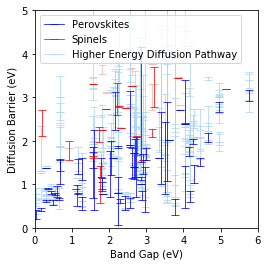

In [11]:
if comps:
    fig_all, ax_all = plt.subplots(figsize=(4, 4))
else:
    fig_all, ax_all = plt.subplots(figsize=(4, 4))


ax_all.plot([-1], [-1], color='blue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.plot([-1], [-1], color='red', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.plot([-1], [-1], color='lightblue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.legend(['Perovskites', 'Spinels', 'Higher Energy Diffusion Pathway'], loc='upper left')
ax_all.set_ylabel('Diffusion Barrier (eV)')
ax_all.set_xlabel('Band Gap (eV)')

ax_all.set_ylim([0,5])
ax_all.set_xlim([0, 6])

labels = []
unit_criteria = {
            'defect_type': {'$exists': False},
            'ts_type': {'$exists': False},
            'material': {'$all': [], '$in': ['spinel', 'perovskite'], '$nin': ['from_zach']},
            'labels' : {
                '$all' : ['unit_cell'],
                '$nin' : ['surface']}
        }

pathway_count = 0
spinel_count = 0
perovskite_count = 0
ub_count = 0
max_diff = 3
ranges = []

for material in list(mat_dict.keys())[:]:
    # if material in done:
    if True:
        try:
            mat = mat_dict[material]
    
            mat_unit_criteria = get_unit_criteria(mat, material)
            units = list(db.database.find(mat_unit_criteria).sort('energy'))
            unit = units[0]
    
            thermo, lb_bars, ub_bars, delta = get_bars(mat, ts_dict[material])
            bars_list = [[unit['band_gap']]*len(thermo), lb_bars, ub_bars]
            for ub, lb in zip(ub_bars[1:], lb_bars[1:]):
                if ub>0 and lb>0:
                    ranges.append(abs(ub-lb))
            plot_full(mat_dict, material, fig_all, ax_all, bars_list, labels=labels, label_all=label_all, string=string,
                      max_diff=max_diff, linewidth=linewidth, plot_higher_barriers=True)
            pathway_count+= 1
        except:
            pass

savefig('bandgap', fig_all)
print(pathway_count)
    # with open('C:\\Users\\RyanTrottier\\PycharmProjects\\untitled\\diffusion_barriers\\materials.csv', 'w', newline='') as csvfile:
    #     writer = csv.writer(csvfile, delimiter=',')
    #     for line in csv_dict.get_list():
    #         writer.writerow(line)

Bond Length

D:\ProgramData\Miniconda3\envs\default\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


98


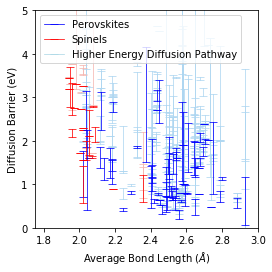

In [12]:
if comps:
    fig_all, ax_all = plt.subplots(figsize=(4, 4))
else:
    fig_all, ax_all = plt.subplots(figsize=(4, 4))


ax_all.plot([-1], [-1], color='blue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.plot([-1], [-1], color='red', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.plot([-1], [-1], color='lightblue', marker='_', linewidth=linewidth, markersize=8, markeredgewidth=linewidth, )
ax_all.legend(['Perovskites', 'Spinels', 'Higher Energy Diffusion Pathway'], loc='upper left')
ax_all.set_ylabel('Diffusion Barrier (eV)')
ax_all.set_xlabel('Average Bond Length ($\AA$)')

ax_all.set_ylim([0,5])
ax_all.set_xlim([1.75, 3.0])

labels = []
unit_criteria = {
            'defect_type': {'$exists': False},
            'ts_type': {'$exists': False},
            'material': {'$all': [], '$in': ['spinel', 'perovskite'], '$nin': ['from_zach']},
            'labels' : {
                '$all' : ['unit_cell'],
                '$nin' : ['surface']}
        }

pathway_count = 0
spinel_count = 0
perovskite_count = 0
ub_count = 0
max_diff = 3
ranges = []

for material in list(mat_dict.keys())[:]:
    # if material in done:
    if True:
        try:
            mat = mat_dict[material]
    
            mat_unit_criteria = get_unit_criteria(mat, material)
            units = list(db.database.find(mat_unit_criteria).sort('energy'))
            unit = units[0]
    
            thermo, lb_bars, ub_bars, delta = get_bars(mat, ts_dict[material])
            bars_list = [[mat['start']['bond']['avg_length']]*len(thermo), lb_bars, ub_bars]
            for ub, lb in zip(ub_bars[1:], lb_bars[1:]):
                if ub>0 and lb>0:
                    ranges.append(abs(ub-lb))
            plot_full(mat_dict, material, fig_all, ax_all, bars_list, labels=labels, label_all=label_all, string=string,
                      max_diff=max_diff, linewidth=linewidth, plot_higher_barriers=True)
            pathway_count+= 1
        except:
            pass

savefig('bondlength', fig_all)
print(pathway_count)

Count

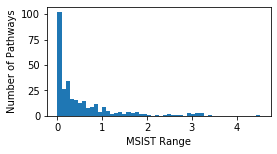

0
103
317
0
0


In [13]:
plt.subplots(figsize=(4,2))
ranges=np.array(ranges)
ranges=ranges[ranges<5]
plt.hist(ranges, bins=50)
plt.ylabel('Number of Pathways')
plt.xlabel('MSIST Range')
savefig('Count')
# plt.xlim([0, 5])

print(count)
print(len(ranges[ranges<0.1]))
print(len(ranges))
print(spinel_count)
print(perovskite_count)

In [14]:
print('''
Energies
NEB: {}
PC:  {}
Tot: {}

Length
NEB: {}
PC:  {}
Tot: {}
'''.format(np.average(neb), np.average(pc), np.average(neb+pc),
           len(neb), len(pc), len(neb+pc)))



Energies
NEB: 0.3599946533333314
PC:  0.28596413534883525
Tot: 0.3271770010309259

Length
NEB: 54
PC:  43
Tot: 97



UB Graphs

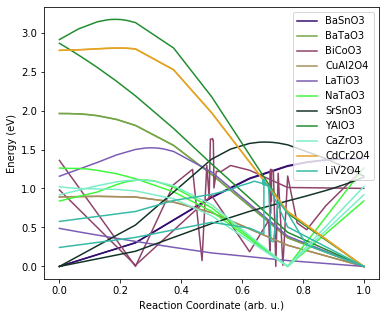

In [15]:
np.random.seed(3)
plt.subplots(figsize=(6, 5))
for label, i in zip(label_list, i_list):
    fraction = 0.15
    mat =label.lower()
    exclude = ['bamno3']
    if mat in exclude:
        continue
    i = i-1
    ub_all = ts_dict[mat]['ub'][i]
    if len(ub_all) != 2 or np.random.rand() > fraction:
        continue
    color = np.random.rand(3,)
    for j in range(2):
        ub = ub_all[j]
        nums = np.array([int(x) for x in ub['dirs']])
        energies = np.array(ub['energies'])
        energies = energies - min(energies)
        plt.plot(nums/10000, energies, c=color, label=label)
        label=None
plt.xlabel('Reaction Coordinate (arb. u.)')
plt.ylabel('Energy (eV)')
plt.legend()
savefig('ub')

Get DOS Information

In [16]:
import numpy as np
import os
import Make_Dos
from Database_Tools import get_file
# vaspruns = {}
try:
    vaspruns
except:
    vaspruns = {}

# ['CaTiO3' 'SrTiO3' 'LaTiO3' 'BiAlO3' 'MgCr2O4' 'SnHfO3' 'BiVO3' 'FeMn2O4'
#  'MgSeO3']
# [1 2 6 1 2 3 2 3 3]

materials_formated = [
#Fast
    ('SnTaO3', 2) ,
    # ('GeNi2O4', 1),
    ('MgAl2O4', 2),
    ('InAlO3', 4),
    ('CoAl2O4', 3),
    ('ZnAl2O4', 3),
    ('LaAlO3', 2),
#Slow
    # ('CaTiO3', 
    # ('SrTiO3', 
    # ('LaTiO3', 
    # ('BiAlO3', 
    # ('MgCr2O4', 
    # ('SnHfO3', 
    # ('MgSeO3', 
    # # 'FeMn2O4', 
    # ('BiVO3'
]


skip = ['gesio3', 'cdcr2o4', 'sntao3', 'znmno3', 'mggeo3', 'geni2o4', 'latio3', 'lacro3', 'bivo3', 'femn2o4',
        'zncr2o4', 'gefe2o4', 'baceo3', 'batio3', 'liv2o4','coseo3', 'cazro3']

dont_skip = ['mgal2o4', 'inalo3', 'coal2o4', 'znal2o4', 'laalo3', 'bialo3', 'snhfo3', 'srtio3', 'mgseo3', 'catio3',]

materials_formated = []
materials_formated += zip(under_mat, under_i)
materials_formated += zip(over_mat, over_i)



materials = [(mat[0].lower(), mat[1]) for mat in materials_formated]
# materials = [('bialo3', 1)]

# i_list = [2, 1, 2, 4, 3, 3, 2,
#           1, 2, 6, 1, 2, 3, 3, 3,2]
# 
# materials = zip(materials, i_list)
progress_i = 1
for material, i in materials:
    print('({}/{}) : {}'.format(progress_i, len(materials), material))
    progress_i += 1
    if material not in dont_skip:
        continue
    # vaspruns[material] = {}
    for run_type in [ 'charged', 'base', 'start', 'lb', 'ts']:
        try:
            vaspruns[material][run_type]
        except:
            try:
                vaspruns[material]
            except:
                vaspruns[material] = {}
            if run_type == 'lb':
                v_file = get_file(fs, ts_dict[material][run_type][i-1]['vasprun'])
            elif run_type == 'charged':
                v_file = get_file(All_Charged_Materials.fs, All_Charged_Materials.mat_dict[material]['start']['vasprun'])
                # v_file = get_file(All_Charged_Materials.fs, All_Charged_Materials.ts_dict[material]['lb'][i-1]['vasprun'])
            elif run_type == 'ts':
                # print('getting TS')
                f = list(db.database.find({'ts_type' : 'neb_dos' , 'material' : material}))
                if len(f) == 0:
                    print('    No Explicit TS')
                    continue
                elif len(f) > 1:
                    raise Exception('Too Many TS')
                v_file = get_file(fs, f[0]['vasprun'])
            else:
                v_file = get_file(fs, mat_dict[material][run_type]['vasprun'])
            vaspruns[material][run_type] = Vasprun(v_file)
            os.remove(v_file)


print('DONE')
used_mats = [x for x in materials if x[0] in dont_skip]
print(used_mats)

(1/50) : srgeo3
(2/50) : znmno3
(3/50) : bacoo3
(4/50) : feal2o4
(5/50) : srcoo3
(6/50) : coga2o4
(7/50) : znga2o4
(8/50) : vmg2o4
(9/50) : pralo3
(10/50) : sntao3
(11/50) : scalo3
(12/50) : mnal2o4
(13/50) : mggeo3
(14/50) : yalo3
(15/50) : laalo3
(16/50) : coseo3
(17/50) : mgal2o4
(18/50) : inalo3
(19/50) : gesio3
(20/50) : coal2o4
(21/50) : cdcr2o4
(22/50) : geni2o4
(23/50) : znal2o4
(24/50) : zncr2o4
(25/50) : gefe2o4
(26/50) : srtio3
    No Explicit TS
(27/50) : catio3
(28/50) : baceo3
(29/50) : latio3
(30/50) : batio3
(31/50) : lacro3
(32/50) : liv2o4
(33/50) : cavo3
(34/50) : bialo3
(35/50) : mgcr2o4
(36/50) : femn2o4
(37/50) : snhfo3
(38/50) : mgseo3
(39/50) : bivo3
(40/50) : bisbo3
(41/50) : cazro3
(42/50) : lamno3
(43/50) : srvo3
(44/50) : bimno3
(45/50) : srseo3
(46/50) : snnio3
(47/50) : laino3
(48/50) : cual2o4
(49/50) : eucro3
(50/50) : zncro3
DONE
[('laalo3', 1), ('mgal2o4', 2), ('inalo3', 4), ('coal2o4', 3), ('znal2o4', 3), ('srtio3', 3), ('catio3', 3), ('bialo3', 1), (

D:\ProgramData\Miniconda3\envs\default\lib\site-packages\pymatgen\io\vasp\outputs.py:907: UserWarning: No POTCAR file with matching TITEL fields was found in C:\Users\theme\AppData\Local\Temp
  " was found in {}".format(os.path.abspath(p)))


Vacancy Comparions

['SrGeO3' 'ZnMnO3' 'BaCoO3' 'FeAl2O4' 'SrCoO3' 'CoGa2O4' 'ZnGa2O4'
 'VMg2O4' 'PrAlO3' 'SnTaO3' 'ScAlO3' 'MnAl2O4' 'MgGeO3' 'YAlO3' 'LaAlO3'
 'CoSeO3' 'MgAl2O4' 'InAlO3' 'GeSiO3' 'CoAl2O4' 'CdCr2O4' 'GeNi2O4'
 'ZnAl2O4' 'ZnCr2O4' 'GeFe2O4']
['SrTiO3' 'CaTiO3' 'BaCeO3' 'LaTiO3' 'BaTiO3' 'LaCrO3' 'LiV2O4' 'CaVO3'
 'BiAlO3' 'MgCr2O4' 'FeMn2O4' 'SnHfO3' 'MgSeO3' 'BiVO3' 'BiSbO3' 'CaZrO3'
 'LaMnO3' 'SrVO3' 'BiMnO3' 'SrSeO3' 'SnNiO3' 'LaInO3' 'CuAl2O4' 'EuCrO3'
 'ZnCrO3']


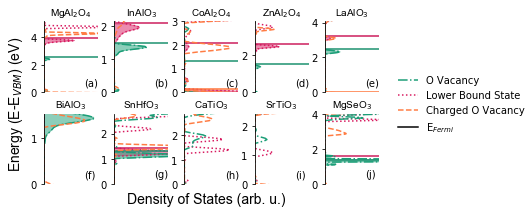

In [17]:
print(under_mat)
print(over_mat)
def get_run(name, prettyname, shifts = (0,0,0,0)):
    return (
        (vaspruns[name]['base'], vaspruns[name]['start'], vaspruns[name]['charged'], vaspruns[name]['lb']),
        shifts,
        prettyname
    )

plots = [
    # get_run('sntao3', 'SnTaO$_3$'),
    # get_run('znmno3', 'ZnMnO$_3$'),
    # get_run('mggeo3', 'MgGeO$_3$'),
    # get_run('geni2o4', 'GeNi$_2$O$_4$'),
    get_run('mgal2o4', 'MgAl$_2$O$_4$'),
    get_run('inalo3', 'InAlO$_3$'),
    get_run('coal2o4', 'CoAl$_2$O$_4$', (0, 0.2, 0, 0.2)),
    get_run('znal2o4', 'ZnAl$_2$O$_4$', (0, 0, 0, -0.2)),
    get_run('laalo3', 'LaAlO$_3$'),
    
    get_run('bialo3', 'BiAlO$_3$', (0,0,0,0.25)),
    get_run('snhfo3', 'SnHfO$_3$'),
    
    get_run('catio3', 'CaTiO$_3$'),
    get_run('srtio3', 'SrTiO$_3$'),
    # get_run('latio3', 'LaTiO$_3$'),
    # get_run('lacro3', 'LaCrO$_3$'),
    # get_run('bivo3', 'BiVO$_3$'),
    # get_run('femn2o4', 'FeMn$_2$O$_4$'),
    get_run('mgseo3', 'MgSeO$_3$'),
]

labels = ['Defect Free', 'O$_{Vac}$', 'O$_{Vac}^{+2}$', 'TS']

'CaTiO3', 'SrTiO3', 'LaTiO3', 'BiAlO3', 'MgCr2O4', 'SnHfO3',


import Make_Dos
from scipy import interpolate
# from scipy.interpolate import splrep as spline
comps=False
amr=False
if comps:
    figsize = (2,3.5)
    ylim = [0,3]
    xlim = [-1,5]
elif amr:
    figsize = (0.8,1.5)
    ylim = [0,0.5]
    xlim = [-1,5]
    plt.subplots(figsize=figsize)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
else:
    figsize=(6,3)
    ylim = [0,0.5]
    xlim = [-1,5]
    fig, ax = plt.subplots(figsize=figsize)
    # ax = fig.add_subplot(111)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)


    #vasprun shift name

def darken_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
font = {'family' : 'Arial'}
title_font = copy.deepcopy(font)
title_font['size'] = 10

plot_efermi = True
label_font = copy.deepcopy(font)
label_font['size'] = 12
points = 1000
colors = ['black', 'blue', 'green', 'red']
linestyles = ['-', '-', '--', '--', '-.', ':']
# if not plot_efermi:
    # colors = ['#7570b3','#1b9e77','#d95f02','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']#
    #1b9e77
colors = ['k', '#004D40', '#FFC107', '#D81B60', '#1E88E5']
colors = ['k', '#004D40', '#ff7c43', '#D81B60', '#1E88E5']
colors = ['k', '#1b9e77', '#ff7c43', '#D81B60', '#1E88E5']
linestyles = ['-', '-.', '--', ':', '-.', ':']
maximum = 2
verbose = False
subplot_i=0
subplot_label = 'a'
for vs, shifts, name in plots:
    if verbose:
        print(name)
    if comps:
        subplot_i += 1
        fig, ax = plt.subplots(figsize=figsize)
        delta = 0.5
        cond_delta = 0
        xlim = [0-delta, vs[0].get_band_structure().get_band_gap()['energy']+delta+cond_delta]
        if name == 'CoAl$_2$O$_4$':
            xlim[1] = 3
    elif amr:
        xlim = [-5, 10]
        xlim = [-3, 3]
        fig, ax = plt.subplots(figsize=figsize)
        delta = 0
        cond_delta = 0
        xlim = [0-delta, vs[0].get_band_structure().get_band_gap()['energy']+delta+cond_delta]
        if name == 'CoAl$_2$O$_4$':
            xlim[1] = 3
    else:
        subplot_i += 1
        ax = plt.subplot(2,5,subplot_i)
        delta = 0
        cond_delta = 0
        xlim = [0-delta, vs[0].get_band_structure().get_band_gap()['energy']+delta+cond_delta]
        if name == 'CoAl$_2$O$_4$':
            xlim[1] = 3
        # xlim = [-1, 5]
    # fig.patch.set_facecolor('white')
    # for i in range(len(vs)-1, -1, -1):
    for i in [3,1,2]:
        vasprun = vs[i]
        shift = shifts[i]
        color = colors[i]
        linestyle=linestyles[i]
        if comps:
            subplot_i += 1
            fig, ax = plt.subplots(figsize=figsize)
            delta = 0.5
            cond_delta = 0
            xlim = [0-delta, vs[0].get_band_structure().get_band_gap()['energy']+delta+cond_delta]
            if name == 'CoAl$_2$O$_4$':
                xlim[1] = 3
        #     if i == 2 or i==0:
        #         continue
    # for vasprun, shift in zip(vaspruns, shifts):
        (title, columns, scaling_factors) = Make_Dos.make_dos(vasprun, ['O'])
        for j in range(1,maximum,2):
            efermi = shift + (vasprun.efermi - vs[0].efermi)
            
            dos = np.array(columns[j]) - np.array(columns[j+1])
            energy = np.array(columns[0])+efermi
            energy_new = np.linspace(energy.min(), energy.max(), points)
            
            tck = interpolate.splrep(energy, dos)
            dos_new = interpolate.splev(energy_new, tck, der=0)
            ax.plot(dos_new, energy_new, color=color, linestyle=linestyle)
            where = energy_new<efermi
            ax.fill_betweenx(energy_new, dos_new, where=where, color=color, alpha=0.5)
    
            # ax.plot(ylim, [efermi, efermi], color=color, linestyle=':', label=labels[i])
            if plot_efermi:
                ax.plot(ylim, [efermi, efermi], color=darken_color(color,1.05), linestyle='-')
            if verbose:
                print('{} {}'.format(labels[i], efermi))
            if comps:
                ax.set_ylim(xlim)
                ax.set_xlim(ylim)
                savefig('{}_{}_{}'.format('dos', name, i))
                
    if not comps and not amr:
        plt.text(0.75, 0.1, '({})'.format(subplot_label),transform=ax.transAxes)
        subplot_label = chr(ord(subplot_label)+1)
   

    # Configure Axis
    label_font = copy.deepcopy(font)
    label_font['size'] = 14

    ax.set_ylim(xlim)
    ax.set_xlim(ylim)
    if not amr:
        ax.set_title(name, fontdict=title_font)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.yaxis.set_ticks_position('left')
    # ax.set_xlabel('DOS (arb. u.)', fontdict=label_font)
    # ax.set_ylabel('Energy (eV)', fontdict=label_font)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
    # if not comps and not amr:
    # ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1)
    #     ax.legend(framealpha=1)
    
    if amr:
        savefig('{}_dos'.format(name))
        # print('{} {} {}'.format(vaspruns[0].get_band_structure().get_band_gap()['energy'], efermi2, efermi3))
        plt.show()
fig.text(0.5, 0.04, 'Density of States (arb. u.)', ha='center', fontdict=label_font)
fig.text(0.04, 0.5, 'Energy (E-E$_{VBM}$) (eV)', va='center', rotation='vertical', fontdict=label_font)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=colors[1], linestyle=linestyles[1], label='O Vacancy'),
    Line2D([0], [0], color=colors[3], linestyle=linestyles[3], label='Lower Bound State'),
    Line2D([0], [0], color=colors[2], linestyle=linestyles[2], label='Charged O Vacancy'),
    ]
if plot_efermi:
    legend_elements += [Line2D([0], [0], color='k', linestyle='-', label='E$_{Fermi}$'),]
# ax = plt.subplot(1,1,1)
fig.legend(handles=legend_elements, loc='center left', frameon=False, bbox_to_anchor=(0.9, 0.5))
savefig('dos')
plt.show()

TS Comparison

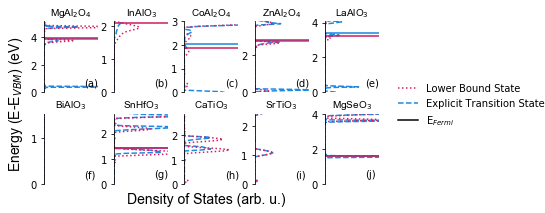

In [18]:
def get_run(name, prettyname, shifts = (0,0,0,0)):
    try:
        return (
            (vaspruns[name]['base'], vaspruns[name]['lb'], vaspruns[name]['ts']),
            shifts,
            prettyname
        )
    except:
        return (
            (vaspruns[name]['base'], vaspruns[name]['lb'], vaspruns[name]['lb']),
            shifts,
            prettyname
        )

plots = [
    # get_run('sntao3', 'SnTaO$_3$'),
    # get_run('znmno3', 'ZnMnO$_3$'),
    # get_run('mggeo3', 'MgGeO$_3$'),
    # get_run('geni2o4', 'GeNi$_2$O$_4$'),
    get_run('mgal2o4', 'MgAl$_2$O$_4$'),
    get_run('inalo3', 'InAlO$_3$', (0,0,0,0)),
    get_run('coal2o4', 'CoAl$_2$O$_4$', (0, 0, 0, 0.2)),
    get_run('znal2o4', 'ZnAl$_2$O$_4$', (0, 0, 0, -0.2)),
    get_run('laalo3', 'LaAlO$_3$'),
    
    get_run('bialo3', 'BiAlO$_3$', (0,0,0,0.25)),
    get_run('snhfo3', 'SnHfO$_3$'),
    
    get_run('catio3', 'CaTiO$_3$'),
    get_run('srtio3', 'SrTiO$_3$'),
    # get_run('latio3', 'LaTiO$_3$'),
    # get_run('lacro3', 'LaCrO$_3$'),
    # get_run('bivo3', 'BiVO$_3$'),
    # get_run('femn2o4', 'FeMn$_2$O$_4$'),
    get_run('mgseo3', 'MgSeO$_3$'),
]


# from scipy.interpolate import splrep as spline
comps=False
amr=False
if comps:
    figsize = (1.5,5)
    ylim = [0,3]
    xlim = [-1,5]
elif amr:
    figsize = (0.8,1.5)
    ylim = [0,0.5]
    xlim = [-1,5]
    plt.subplots(figsize=figsize)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
else:
    figsize=(6,3)
    ylim = [0,0.5]
    xlim = [-1,5]
    fig, ax = plt.subplots(figsize=figsize)
    # ax = fig.add_subplot(111)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)


    #vasprun shift name
points = 1000
colors = ['black', 'blue', 'green', 'red']
linestyles = ['-', '-', '--', '--', '-.', ':']
# if not plot_efermi:
    # colors = ['#7570b3','#1b9e77','#d95f02','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']#
# colors = ['k', '#004D40', '#FFC107', '#1E88E5', '#D81B60']
colors = ['k', '#004D40', '#ff7c43', '#D81B60', '#1E88E5']
colors = ['k', '#D81B60', '#1E88E5', '#004D40', '#ff7c43']
linestyles = ['-', ':','--', '-.', '--', ':', '-.', ':']
maximum = 2
verbose = False
subplot_i=0
subplot_label = 'a'
for vs, shifts, name in plots:
    if verbose:
        print(name)
    if comps:
        xlim = [-5, 10]
        xlim = [-3, 3]
        fig, ax = plt.subplots(figsize=figsize)
    elif amr:
        xlim = [-5, 10]
        xlim = [-3, 3]
        fig, ax = plt.subplots(figsize=figsize)
        delta = 0
        cond_delta = 0
        xlim = [0-delta, vs[0].get_band_structure().get_band_gap()['energy']+delta+cond_delta]
        if name == 'CoAl$_2$O$_4$':
            xlim[1] = 3
    else:
        subplot_i += 1
        ax = plt.subplot(2,5,subplot_i)
        delta = 0
        cond_delta = 0
        xlim = [0-delta, vs[0].get_band_structure().get_band_gap()['energy']+delta+cond_delta]
        if name == 'CoAl$_2$O$_4$':
            xlim[1] = 3
        # xlim = [-1, 5]
    # fig.patch.set_facecolor('white')
    # for i in range(len(vs)-1, -1, -1):
    for i in [2,1]:
    #     if i == 2 or i==0:
    #         continue
        vasprun = vs[i]
        shift = shifts[i]
        color = colors[i]
        linestyle=linestyles[i]
    # for vasprun, shift in zip(vaspruns, shifts):
        (title, columns, scaling_factors) = Make_Dos.make_dos(vasprun, ['O'])
        for j in range(1,maximum,2):
            efermi = shift + (vasprun.efermi - vs[0].efermi)
            
            dos = np.array(columns[j]) - np.array(columns[j+1])
            energy = np.array(columns[0])+efermi
            energy_new = np.linspace(energy.min(), energy.max(), points)
            
            tck = interpolate.splrep(energy, dos)
            dos_new = interpolate.splev(energy_new, tck, der=0)
            ax.plot(dos_new, energy_new, color=color, linestyle=linestyle)
            where = energy_new<efermi
            # ax.fill_betweenx(energy_new, dos_new, where=where, color=color, alpha=0.5)
    
            # ax.plot(ylim, [efermi, efermi], color=color, linestyle=':', label=labels[i])
            if plot_efermi:
                ax.plot(ylim, [efermi, efermi], color=darken_color(color,1.05), linestyle='-')
            if verbose:
                print('{} {}'.format(labels[i], efermi))
    if not comps and not amr:
        plt.text(0.75, 0.1, '({})'.format(subplot_label),transform=ax.transAxes)
        subplot_label = chr(ord(subplot_label)+1)
   

    # Configure Axis
    label_font = copy.deepcopy(font)
    label_font['size'] = 14

    ax.set_ylim(xlim)
    ax.set_xlim(ylim)
    if not amr:
        ax.set_title(name, fontdict=title_font)
    ax.set_xticks([])
    # ax.set_yticks([])
    ax.yaxis.set_ticks_position('left')
    # ax.set_xlabel('DOS (arb. u.)', fontdict=label_font)
    # ax.set_ylabel('Energy (eV)', fontdict=label_font)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    handles, labels = ax.get_legend_handles_labels()
    # if not comps and not amr:
    # ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1)
    #     ax.legend(framealpha=1)
    
    if comps or amr:
        savefig('{}_ts_dos'.format(name))
        # print('{} {} {}'.format(vaspruns[0].get_band_structure().get_band_gap()['energy'], efermi2, efermi3))
        plt.show()
fig.text(0.5, 0.04, 'Density of States (arb. u.)', ha='center', fontdict=label_font)
fig.text(0.04, 0.5, 'Energy (E-E$_{VBM}$) (eV)', va='center', rotation='vertical', fontdict=label_font)
from matplotlib.lines import Line2D
legend_elements = [
    # Line2D([0], [0], color=colors[3], linestyle=linestyles[1], label='O Vacancy'),
    Line2D([0], [0], color=colors[1], linestyle=linestyles[1], label='Lower Bound State'),
    Line2D([0], [0], color=colors[2], linestyle=linestyles[2], label='Explicit Transition State'),
    # Line2D([0], [0], color=colors[2], linestyle=linestyles[2], label='Charged O Vacancy'),
    ]
if plot_efermi:
    legend_elements += [Line2D([0], [0], color='k', linestyle='-', label='E$_{Fermi}$'),]
# ax = plt.subplot(1,1,1)
fig.legend(handles=legend_elements, loc='center left', frameon=False, bbox_to_anchor=(0.9, 0.5))
savefig('dos_ts')
plt.show()


Load Charged

Setup Bandgaps

In [19]:
label_list = []
lb = []
lb0 = []
avgs = []
avgs0 = []
err = []
err0 = []
minmax = 0.05

unit_criteria = {
            'defect_type': {'$exists': False},
            'ts_type': {'$exists': False},
            'material': {'$all': [], '$in': ['spinel', 'perovskite'], '$nin': ['from_zach']},
            'labels' : {
                '$all' : ['unit_cell'],
                '$nin' : ['surface']}
        }

import All_Charged_Materials
for material in All_Charged_Materials.mat_dict.keys():
    # for material in ['cual2o4']:
    mat = All_Charged_Materials.mat_dict[material]
    thermo,  lb_bars,  ub_bars,  delta = get_bars(mat, All_Charged_Materials.ts_dict[material])
    thermo0, lb0_bars, ub0_bars, delta = get_bars(mat, All_Charged_Materials.ts_dict[material], suffix='0')
    if material == 'bazro3':
        pass
    # print(lb_bars, lb0_bars)
    bars_list = [thermo, lb_bars, ub_bars]

    metal_material = ['srcoo3', 'mgcr2o4', 'batao3', 'basno3']

    ranges = np.array(ub_bars) - np.array(lb_bars)
    ranges = np.array([ x if x > 0 else 0 for x in ranges])
    avg = np.array(lb_bars) + ranges/2 #type:np.array
    if max(avg) > 0:
        if material in metal_material:
            label_list.append(material)
            ranges0 = np.array(ub0_bars) - np.array(lb0_bars)
            ranges0 = np.array([ x if x > 0 else 0 for x in ranges0])
            avg0 = np.array(lb0_bars) + ranges0/2
            i = list(avg).index(min([ x for x in avg if x > 0 ]))
            delta = abs(thermo[0] - thermo[i])
            lb.append(lb_bars[i] -delta) 
            err.append(max(ranges[i], minmax))
            i0 = list(avg0).index(min([ x for x in avg0 if x > 0 ]))
            lb0.append(lb0_bars[i0])
            err0.append(max(ranges0[i0], minmax))
            avgs.append(avg[i0])
            avgs0.append(avg0[i0])
            continue
        label_list.append(material)
        ranges0 = np.array(ub0_bars) - np.array(lb0_bars)
        ranges0 = np.array([ x if x > 0 else 0 for x in ranges0])
        avg0 = np.array(lb0_bars) + ranges0/2
        i = list(avg).index(min([ x for x in avg if x > 0 ]))
        lb.append(lb_bars[i])
        err.append(max(ranges[i], minmax))
        i0 = list(avg0).index(min([ x for x in avg0 if x > 0 ]))
        lb0.append(lb0_bars[i0])
        err0.append(max(ranges0[i0], minmax))
        avgs.append(avg[i0])
        avgs0.append(avg0[i0])
    elif min(avg) < 0:
        pass
        # del mat_dict[material]
        # del ts_dict[material]
    else:
        label_list.append(material)
        lb.append(0)
        lb0.append(0)
        err.append(0)
        err0.append(0)

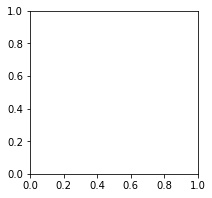

In [20]:
maxrange = 1
plt.subplots(figsize=(3,3))
x = np.array(lb0) + np.array(err0)/2
y = np.array(lb) + np.array(err)/2
xerr = np.array(err0)/2
yerr = np.array(err)/2

x = x[np.where(xerr < maxrange)]
y = y[np.where(xerr < maxrange)]
yerr = yerr[np.where(xerr < maxrange)]
ll = np.array(label_list)[np.where(xerr < maxrange)]

xerr = xerr[np.where(xerr < maxrange)]
# 
# 
# 

In [21]:
color = []
progress_i = 0
for material in ll:
    # print('({}/{}) : {}'.format(progress_i, len(ll), material))
    progress_i += 1
    f=get_file(fs, mat_dict[material]['base']['vasprun'])
    vasprun = Vasprun(f)
    color.append(vasprun.get_band_structure().get_band_gap()['energy'])
    os.remove(f)
# color.append(mat_dict[material]['base']['descriptors']['bandgap'])
# 

print('DONE')

DONE


Charged Plot

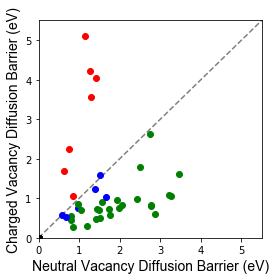


Faster    7
Slower    25 
Ambiguous 5
Undecided 6
[]
[]
[]
[]


In [22]:
# #
maxbarrier = 5.5
if comps:
    plt.figure(figsize=[4,4])
else:
    label_font = copy.deepcopy(font)
    label_font['size'] = 14
    plt.figure(figsize=[4,4])
    
plt.plot([0, maxbarrier], [0, maxbarrier], '--', color='gray')
# scat = plt.scatter(x, y, c=color, marker='o')
# clb = plt.colorbar(label='Band Gap (eV)')
# e1, e2, e3 = plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='none', color='k')
# scat = plt.scatter(x, y, marker='o')
# clb = plt.colorbar(scat, label='Band Gap (eV)')
# error_color = clb.to_rgba(color)
# e3[0].set_color(error_color)
# plt.colorbar(scat, label='V$_O$ Energy (eV)')
plt.xlabel('Neutral Vacancy Diffusion Barrier (eV)', fontdict=label_font)
plt.ylabel('Charged Vacancy Diffusion Barrier (eV)', fontdict=label_font)
plt.xlim([0,maxbarrier])
plt.ylim([0,maxbarrier])
# for i in range(len(ll)):
#     plt.text(x[i], y[i], ll[i])

faster = 0
undecided = 0
ambiguous = 0
slower = 0
up = ['mgal2o4', 'inalo3', 'coal2o4', 'znal2o4', 'laalo3']
op = ['catio3', 'srtio3', 'bialo3', 'snhfo3', 'mgseo3']
up_e = []
up_l = []
op_e = []
op_l = []
error_color = color
for xp, yp, xerrp, yerrp, colorp, bg, label in zip(x, y, xerr, yerr, error_color, color, ll):
    colorp='k'
    if bg > 0 :
        pass
      # if label in up+op:
      #   plt.plot(xp, yp, 'o', color=colorp, markersize=6)
      #   plt.errorbar(xp, yp,  xerr=xerrp, yerr=yerrp, lw=1, capsize=3, color=colorp)
        # print(xp, yp)
        # plt.text(xp, yp, label)
        # if label in up:
        #     up_e += [yp - xp]
        #     up_l += [label]
        # 
        # if label in op:
        #     op_e += [yp - xp]
        #     op_l += [label]

              
    else:
        continue
    if xp + xerrp < yp - yerrp:
        faster += 1
        colorp = 'red'
    elif yp + yerrp < xp - xerrp:
        slower += 1
        colorp = 'green'
    elif xerrp*2 < 0.1 and yerrp*2<0.1:
        ambiguous += 1
        colorp = 'black'
    else:
        undecided += 1
        colorp = 'blue'
    plt.plot(xp, yp, 'o', color=colorp, markersize=6)
    
savefig('chargedvsneutral')
plt.show()

print('''
Faster    {}
Slower    {} 
Ambiguous {}
Undecided {}'''.format(faster, slower, ambiguous, undecided))
# print('''
# Overpredicted delta: {} 
# Underprdicted delta: {}'''.format(sum(op_e)/len(op_e), sum(up_e)/len(up_e)))
print(op_e)
print(op_l)
print(up_e)
print(up_l)

In [23]:
# # figsize = (10,5)
# # font = {
# #     'family' : 'Arial',
# #     'size' : 12,
# # }
# # label_font = copy.deepcopy(font)
# # label_font['size'] = 14
# # 
# # tick_font = copy.deepcopy(font)
# # tick_font['size'] = 9
# # labels = {
# #     'bacoo3' : 'BaCoO$_3$',
# #     'bafeo3' : 'BaFeO$_3$'
# # }
# # def make_plot(bars_list, bottoms, legend=[], colors=['k', 'r', 'b'], ylim=None, ylabel='',label_list=label_list):
# #     width = .15 / len(bars_list)
# #     x = np.arange(len(bars_list[0]))
# #     fig, ax = plt.subplots(figsize=figsize)
# #     fig.patch.set_facecolor('white')
# #     
# #     for i, bars in enumerate(bars_list):
# #         rects = plt.errorbar(x + i * width, bars, color=colors[i], label=legend[i], yerr=np.array(bottoms[i])/2,
# #                              fmt='o', markersize=0, linewidth=10)
# #     lables = ax.set_xticklabels([ labels[x] if x in labels else x for x in label_list], fontdict=tick_font)
# #     ax.set_ylabel(ylabel, fontdict=label_font)
# #     
# #     ticks = ax.set_xticks(x + width * (len(bars_list)-1) / 2)
# #     # ticks = ax.set_xticks(x)
# #     if ylim:
# #         ax.set_ylim(ylim)
# #     plt.show()
# # 
# # make_plot([lb, lb0], [err, err0], legend=['+2', '0'])
# 

In [24]:
# # figsize = (10,5)
# # font = {
# #     'family' : 'Arial',
# #     'size' : 12,
# # }
# # label_font = copy.deepcopy(font)
# # label_font['size'] = 14
# # 
# # tick_font = copy.deepcopy(font)
# # tick_font['size'] = 9
# # labels = {
# #     'bacoo3' : 'BaCoO$_3$',
# #     'bafeo3' : 'BaFeO$_3$'
# # }
# # def make_plot(bars_list, bottoms, legend=[], colors=['k', 'r', 'b'], ylim=None, ylabel='',label_list=label_list):
# #     width = .15 / len(bars_list)
# #     x = np.arange(len(bars_list[0]))
# #     fig, ax = plt.subplots(figsize=figsize)
# #     fig.patch.set_facecolor('white')
# #     
# #     for i, bars in enumerate(bars_list):
# #         rects = plt.errorbar(x + i * width, bars, color=colors[i], label=legend[i], yerr=np.array(bottoms[i])/2,
# #                              fmt='o', markersize=0, linewidth=10)
# #     lables = ax.set_xticklabels([ labels[x] if x in labels else x for x in label_list], fontdict=tick_font)
# #     ax.set_ylabel(ylabel, fontdict=label_font)
# #     
# #     ticks = ax.set_xticks(x + width * (len(bars_list)-1) / 2)
# #     # ticks = ax.set_xticks(x)
# #     if ylim:
# #         ax.set_ylim(ylim)
# #     plt.show()
# # 
# # make_plot([lb, lb0], [err, err0], legend=['+2', '0'])
# 

In [25]:
# # figsize = (10,5)
# # font = {
# #     'family' : 'Arial',
# #     'size' : 12,
# # }
# # label_font = copy.deepcopy(font)
# # label_font['size'] = 14
# # 
# # tick_font = copy.deepcopy(font)
# # tick_font['size'] = 9
# # labels = {
# #     'bacoo3' : 'BaCoO$_3$',
# #     'bafeo3' : 'BaFeO$_3$'
# # }
# # def make_plot(bars_list, bottoms, legend=[], colors=['k', 'r', 'b'], ylim=None, ylabel='',label_list=label_list):
# #     width = .15 / len(bars_list)
# #     x = np.arange(len(bars_list[0]))
# #     fig, ax = plt.subplots(figsize=figsize)
# #     fig.patch.set_facecolor('white')
# #     
# #     for i, bars in enumerate(bars_list):
# #         rects = plt.errorbar(x + i * width, bars, color=colors[i], label=legend[i], yerr=np.array(bottoms[i])/2,
# #                              fmt='o', markersize=0, linewidth=10)
# #     lables = ax.set_xticklabels([ labels[x] if x in labels else x for x in label_list], fontdict=tick_font)
# #     ax.set_ylabel(ylabel, fontdict=label_font)
# #     
# #     ticks = ax.set_xticks(x + width * (len(bars_list)-1) / 2)
# #     # ticks = ax.set_xticks(x)
# #     if ylim:
# #         ax.set_ylim(ylim)
# #     plt.show()
# # 
# # make_plot([lb, lb0], [err, err0], legend=['+2', '0'])
# 


Bader

In [26]:
# from File_Management import get_bader
# delta = 0.01
# 
# 
# for m in ['nasbo3']:
#     base_out_f = get_file(fs, mat_dict[m]['base']['outcar'])
#     base_out = Outcar(base_out_f)
#     base_charge = base_out.charge
#     base_s = Poscar.from_dict(mat_dict[m]['base']['poscar']).structure
#     os.remove(base_out_f)
#     
#     start_out_f = get_file(fs, mat_dict[m]['start']['outcar'])
#     start_out = Outcar(start_out_f)
#     start_charge = start_out.charge
#     os.remove(start_out_f)
#     start_s = Poscar.from_dict(mat_dict[m]['start']['poscar']).structure
#     
#     base_charges = {}
#     for i in range(len(base_s)):
#         a = base_s[i]
#         c = base_charge[i]['tot']
#         if a.specie in base_charges:
#             base_charges[a.specie] = (base_charges[a.specie][0]+c, base_charges[a.specie][1]+1)
#         else:
#             base_charges[a.specie] = (c, 1)
#     base_charges = { k: base_charges[k][0] / base_charges[k][1] for k in base_charges}
#     
#     for i in range(len(base_s)):
#         a = base_s[i]
#         c = base_charge[i]['tot']
#         if abs(base_charges[a.specie] - c) > delta:
#             raise Exception('Large Deviations')
#         
#     
#     for i in range(len(start_s)):
#         a = start_s[i]
#         c = start_charge[i]['tot']
#         deviation = base_charges[a.specie] - c
#         if abs(deviation) > delta:
#             print('Deviation of {} for {} {} in {}'.format(deviation, a.specie, i, m))

# class BaderAtomNumber:
# 
#     def __init__(self, d):
#         self.dict = d
# 
#     default_charges = {
#         'Fe': 14,
#         'Al': 3,
#         'O': 6
#     }
# 
#     def convert_dict(self, d, i):
#         return d['bader_acf']['charge'][i]
# 
#     def atom_number(self, description):
#         """
# 
#         :param description: Hercynite environment description
#         :return: int based on description or default as provided during initialization
#         """
#         if description in self.dict:
#             return self.dict[description]
#         else:
#             return self.dict['default']
# 
#     def charge(self, acf, structure: Structure, description):
#         charges = []
#         atom_numbers = self.atom_number(description)
#         if type(atom_numbers) == int:
#             atom_numbers = [atom_numbers]
# 
#         for atom_number in atom_numbers:
#             charges.append(self.default_charges[structure[atom_number].specie.name] - float(self.convert_dict(acf, atom_number)))
#         return charges
# 
#     def charge_by_element(self, acf, structure: Structure, element):
#         charges = []
#         for i, a in enumerate(structure):
#             if a.specie == element:
#                 charges.append(self.default_charges[a.specie.name] - float(self.convert_dict(acf, i)))
#         return charges
# 
#     def charge_by_element_generator(self, element):
#         def consistent_args(acf, structure, description):
#             return self.charge_by_element(acf, structure, element)
#         return consistent_args


Random Plotting

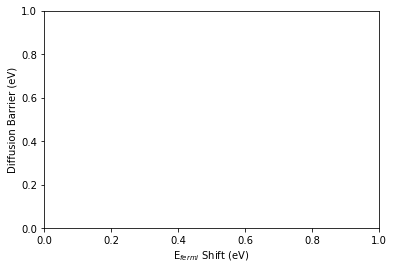

In [27]:

import scipy
cutoff = 5
min_cutoff = -100


x=np.array(csv_dict.get_column('ovac_final'))
y=np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2
x=x[np.where(y<cutoff)]
y=y[np.where(y<cutoff)]
linreg = scipy.stats.linregress(x, y)
prediction = linreg.intercept + linreg.slope * np.array(csv_dict.get_column('ovac_final'))


x=np.array(csv_dict.get_column('ts_efermi'))-np.array(csv_dict.get_column('efermi'))
# x= abs(x)
y=np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2
s=abs(np.array(csv_dict.get_column('ub'))-np.array(csv_dict.get_column('lb')))*500
marker='|'
plt.xlabel('E$_{fermi}$ Shift (eV)')
plt.ylabel('Diffusion Barrier (eV)')
plt.show()

# x=abs(np.array(csv_dict.get_column('formation_energy'))) + \
#   0.6*(np.array((csv_dict.get_column('o_p_band_center')) + 1.5/2*np.array(csv_dict.get_column('band_gap')))) + \
#   2.6*np.array(csv_dict.get_column('pauling_diff'))

# plt.ylabel('V$_{O}$ Energy (eV)')
# plt.xlabel('Deml')

# plt.ylabel('E$_{fermi}$ Shift (eV)')
# plt.xlabel('Band Gap (eV)')
#
# color=np.array(csv_dict.get_column('band_gap'))

# Band Gap
# np.array(csv_dict.get_column('band_gap'))

# Ovac
# np.array(csv_dict.get_column('ovac_final'))

# TS
# np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2
# prediction - ( np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2 )

# Fermi Shift
# np.array(csv_dict.get_column('ts_efermi'))-np.array(csv_dict.get_column('efermi'))
# np.array(csv_dict.get_column('efermi_vac'))-np.array(csv_dict.get_column('efermi'))
# np.array(csv_dict.get_column('ts_efermi'))-np.array(csv_dict.get_column('efermi_vac'))

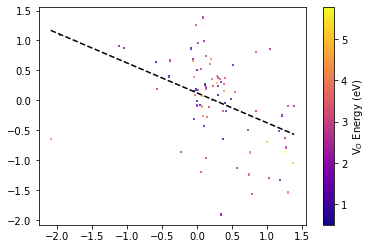

<Figure size 216x216 with 0 Axes>

LinregressResult(slope=-0.4992271264900983, intercept=0.12333142853735568, rvalue=-0.44865461901084336, pvalue=2.3642558480831786e-05, stderr=0.11118221881136096)


In [28]:
x=np.array(csv_dict.get_column('ts_efermi'))-np.array(csv_dict.get_column('efermi_vac'))
y= prediction - ( np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2 )
color=np.array(csv_dict.get_column('band_gap'))
s=abs(np.array(csv_dict.get_column('ub'))-np.array(csv_dict.get_column('lb')))*500

cutoff = 5
min_cutoff = -5
s=s[np.where(y<cutoff)]
x=x[np.where(y<cutoff)]
color=color[np.where(y<cutoff)]
y=y[np.where(y<cutoff)]

s=s[np.where(y>min_cutoff)]
x=x[np.where(y>min_cutoff)]
color=color[np.where(y>min_cutoff)]
y=y[np.where(y>min_cutoff)]

color_cutoff = 0.5
s=s[np.where(color>color_cutoff)]
x=x[np.where(color>color_cutoff)]
y=y[np.where(color>color_cutoff)]
color=color[np.where(color>color_cutoff)]

s=5

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
scat = plt.scatter(x, y, c=color, s=s, cmap='plasma', marker=marker)
plt.colorbar(scat, label='V$_O$ Energy (eV)')
plt.plot([min(x), max(x)], [p(min(x)), p(max(x))], "--", color='k')
plt.figure(figsize=(3,3))
plt.show()
print(scipy.stats.linregress(x, y))
# for property in csv_dict.get_header()[6:]:
#     y = prediction - (np.array(csv_dict.get_column('lb')) / 2 + np.array(csv_dict.get_column('ub')) / 2)
#     x = np.array(csv_dict.get_column(property))
#     x=x[np.where(y>min_cutoff)]
#     y=y[np.where(y>min_cutoff)]
#     linreg = scipy.stats.linregress(x, y)
#
#     print(property)
#     print(linreg.rvalue)

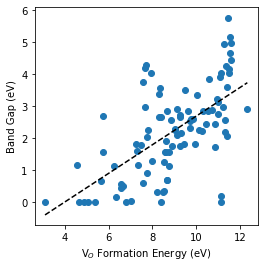

LinregressResult(slope=0.44703810590367143, intercept=-1.7774351036074827, rvalue=0.6274713279158494, pvalue=6.090681125625573e-12, stderr=0.05691482190727916)


In [29]:
plt.figure(figsize=(4,4))
x=np.array(csv_dict.get_column('ovac'))
y=np.array(csv_dict.get_column('band_gap'))
plt.xlabel('V$_O$ Formation Energy (eV)')
plt.ylabel('Band Gap (eV)')
# y= prediction - ( np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2 )

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
scat = plt.scatter(x, y)
plt.plot([min(x), max(x)], [p(min(x)), p(max(x))], "--", color='k')
savefig('bg_vs_vo')
print(scipy.stats.linregress(x, y))


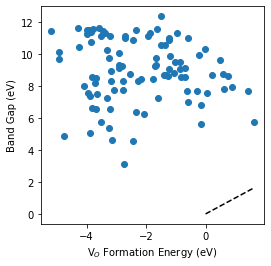

LinregressResult(slope=-0.12522231441931303, intercept=8.649240344688193, rvalue=-0.09953117307992634, pvalue=0.33206059658110276, stderr=0.1284395915145879)


In [30]:
from scipy.optimize import curve_fit

plt.figure(figsize=(4,4))
x=np.array(csv_dict.get_column('formation_energy'))+0.6*(-(np.array(csv_dict.get_column('o_p_band_center')))+1.5/2*np.array(csv_dict.get_column('band_gap')))+2.6*np.array(csv_dict.get_column('pauling_diff'))
x=np.array(csv_dict.get_column('formation_energy'))+0.6*(-(np.array(csv_dict.get_column('o_p_band_center')))+1.5/2*np.array(csv_dict.get_column('band_gap')))-2.6*np.array(csv_dict.get_column('pauling_diff'))
# x=[
#     np.array(csv_dict.get_column('formation_energy')),
#     np.array(csv_dict.get_column('o_p_band_center'))-np.array(csv_dict.get_column('efermi')),
#     np.array(csv_dict.get_column('band_gap')),
#     np.array(csv_dict.get_column('pauling_diff'))
#     ]
y=np.array(csv_dict.get_column('ovac'))
plt.xlabel('V$_O$ Formation Energy (eV)')
plt.ylabel('Band Gap (eV)')
# y= prediction - ( np.array(csv_dict.get_column('lb'))/2+np.array(csv_dict.get_column('ub'))/2 )

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
scat = plt.scatter(x, y)
plt.plot([0, max(x)], [0, max(x)], "--", color='k')
savefig('bg_vs_vo')
print(scipy.stats.linregress(x, y))


